<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week10_1_EOF_partIII_globalSST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (94.5 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [ ]:
!pip install eofs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100374 sha256=b5737d16a6e5b903bb4fbd37ef8213511a958bee005a0efcc90e404a436a56c3
  Stored in directory: /root/.cache/pip/wheels/ce/4e/36/2ef48d7342cd326d5f3bdb4ddd0441f06b387b5cbfc8336095
Successfully built eofs


In [6]:
#url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#ds = xr.open_dataset(url)
ds = xr.open_dataset("/content/drive/MyDrive/Colab_data/ERSST_V5_mon_185401-202106.nc")

# select period
ds = ds.sel(time=slice('1900', '2020'))

#actually load the data
ds.load()

ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))
ds_sst=ds_anoms.sel(lat=slice(-70,70),lon=slice(0,360))

sst = ds_sst['sst']

In [7]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eofs = solver.eofsAsCorrelation(neofs=4)
pcs = solver.pcs(npcs=4, pcscaling=1)
vars = solver.varianceFraction(neigs=4)

In [8]:
vars

<xarray.DataArray 'variance_fractions' (mode: 4)>
array([0.23241276, 0.10896286, 0.03367034, 0.0306509 ], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3
Attributes:
    long_name:  variance_fractions

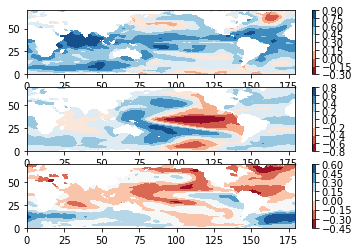

In [9]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(eofs[i,:,:],cmap='RdBu')
    plt.colorbar()

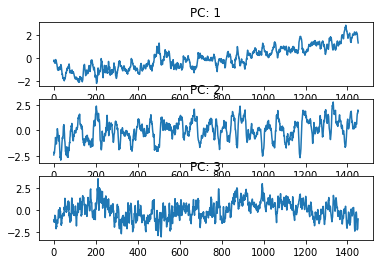

In [10]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=pcs[:,i]
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)

In [11]:
reconstruction = solver.reconstructedField(2)

In [12]:
reconstruction

<xarray.DataArray 'sst' (time: 1452, lat: 71, lon: 180)>
array([[[        nan, -0.03282435, -0.03121167, ..., -0.0372777 ,
         -0.02107156, -0.02397541],
        [-0.06381944, -0.07132697, -0.06189517, ..., -0.03174767,
         -0.0486634 , -0.05582889],
        [-0.04410637, -0.04824076, -0.05844031, ..., -0.0467648 ,
         -0.03274534, -0.03448385],
        ...,
        [-0.20697533, -0.23863292, -0.28847843, ..., -0.20132148,
         -0.19813079, -0.19744267],
        [-0.22045797, -0.24829313, -0.28679845, ..., -0.2194532 ,
         -0.20291921, -0.20441167],
        [-0.25763527, -0.28049892, -0.31891784, ..., -0.2716887 ,
         -0.25804827, -0.25674698]],

       [[        nan, -0.02595448, -0.02475406, ..., -0.02972879,
         -0.0161546 , -0.01795328],
        [-0.04907243, -0.0550884 , -0.04734035, ..., -0.02341237,
         -0.03673079, -0.04261849],
        [-0.03247321, -0.0360613 , -0.04448117, ..., -0.03482989,
         -0.02227067, -0.02375085],
...
        [ 0.4104896 ,  0.45717868,  0.52787584, ...,  0.37283775,
          0.37693632,  0.38816893],
        [ 0.4291512 ,  0.47388297,  0.5384916 , ...,  0.39348343,
          0.3856601 ,  0.39978722],
        [ 0.45648858,  0.49635655,  0.5577427 , ...,  0.45083398,
          0.4435975 ,  0.4476734 ]],

       [[        nan,  0.06978162,  0.06541653, ...,  0.07607831,
          0.05114839,  0.06355559],
        [ 0.15309604,  0.16805749,  0.1516439 , ...,  0.08868226,
          0.12535776,  0.1378102 ],
        [ 0.12386987,  0.12866142,  0.1458958 , ...,  0.12633021,
          0.11499794,  0.11737134],
        ...,
        [ 0.37924448,  0.42268753,  0.48854187, ...,  0.3449641 ,
          0.34855133,  0.35868812],
        [ 0.39664012,  0.4381673 ,  0.49808294, ...,  0.3643311 ,
          0.3566259 ,  0.3694642 ],
        [ 0.42278373,  0.45972174,  0.51671857, ...,  0.4182005 ,
          0.41113597,  0.4147744 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2020-12-01
  * lat      (lat) float32 -70.0 -68.0 -66.0 -64.0 -62.0 ... 64.0 66.0 68.0 70.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  sst_reconstructed_with_2_EOFs